<a href="https://colab.research.google.com/github/mariyagolchin/Brain-Tumor-Detection/blob/main/1_Brain_Tumor_Detection_using_CNN_and_tranfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Detection using CNN and tranfer learning
Brain-Tumor-MRI-InceptionResNetV2-85%accuracy

https://www.kaggle.com/saumya5679/brain-tumor-mri-inceptionresnetv2-85-accuracy

**Brain Tumor Detection using CNN and tranfer learning**

We will create a model which will correctly classify if the MRI image of the brain has tumor or not.

**Importing necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
# from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers import Adam, SGD, RMSprop # - Works
from keras import backend as K

import cv2
import shutil
import glob
import os

In [3]:
# Data import & preprocessing
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/KaggleData/Brain MRI Images.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/KaggleData/Brain MRI Images")
zip_ref.close()


In [2]:
data = '/content/drive/MyDrive/KaggleData/Brain MRI Images/'
No_brain_tumor = '/content/drive/MyDrive/KaggleData/Brain MRI Images/brain_tumor_dataset/no/'
Yes_brain_tumor = '/content/drive/MyDrive/KaggleData/Brain MRI Images/brain_tumor_dataset/yes/'

In [3]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [4]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/KaggleData/Brain MRI Im...,No
1,/content/drive/MyDrive/KaggleData/Brain MRI Im...,No
2,/content/drive/MyDrive/KaggleData/Brain MRI Im...,No
3,/content/drive/MyDrive/KaggleData/Brain MRI Im...,No
4,/content/drive/MyDrive/KaggleData/Brain MRI Im...,No


In [5]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


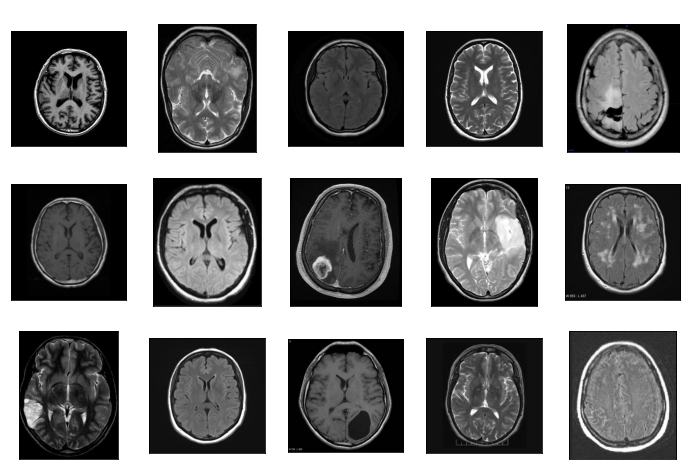

In [6]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


Let's start the modelling task The ImageDataGenerator for keras is awesome. It lets you augment your images in real-time while your model is still training! You can apply any random transformations on each training image as it is passed to the model. This will not only make your model robust but will also save up on the overhead memory!

We will apply the Image Data Generator on training with various parameters, but we won't apply the same parameters on testin. Why? Because we want the test iamges as it is, we don't want biasedness, also if we fit it we will be applying the model only on these test images only, it can't predict new images if fed into model Because new images will not be augmented this way

In [8]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation

In [9]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [10]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

# CNN model

In [11]:

base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

219070464/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 54,534,113
Trainable params: 54,473,313
N

In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, 
                    callbacks = [callbacks], verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/40
14/14 [==============================] - 99s 3s/step - loss: 0.7685 - accuracy: 0.5880 - val_loss: 0.9572 - val_accuracy: 0.5000
Epoch 2/40
14/14 [==============================] - 6s 439ms/step - loss: 0.5141 - accuracy: 0.7824 - val_loss: 0.4238 - val_accuracy: 0.8750
Epoch 3/40
14/14 [==============================] - 6s 455ms/step - loss: 0.4780 - accuracy: 0.7824 - val_loss: 0.5907 - val_accuracy: 0.8333
Epoch 4/40
14/14 [==============================] - 6s 440ms/step - loss: 0.4013 - accuracy: 0.8194 - val_loss: 0.4506 - val_accuracy: 0.9167
Epoch 5/40
14/14 [==============================] - 6s 440ms/step - loss: 0.4202 - accuracy: 0.8056 - val_loss: 0.4811 - val_accuracy: 0.8333
Epoch 00005: early stopping


In [13]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

1/1 [==============================] - 1s 1s/step - loss: 0.4551 - accuracy: 0.8462


[0.45506709814071655, 0.8461538553237915]

# plot model performance

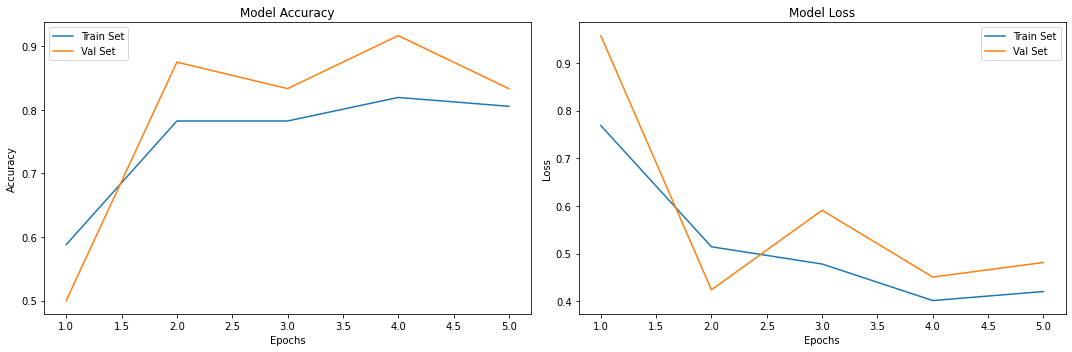

In [15]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()
